In [1]:
import pyodbc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.anomaly import *

In [2]:
## Conexion al DWH
cnxn = pyodbc.connect(
    driver='{SQL Server}',
    server='192.168.100.58',
    uid='bilectura',
    pwd='D1sp@p3l3s')
cursor = cnxn.cursor()
#cnxn.close()

In [3]:
fecha_inicio = "'2022-01-01'"
fecha_final = "'2023-01-31'"

In [4]:
codigo_SQL = f"SELECT A.VTAANO AS 'Ano', A.VTAMES AS 'Mes', A.DSTCOD AS 'Codigo distrito', A.VTAZNA AS 'Codigo zona', A.VTANIT AS 'Nit cliente', C.NITNOM AS 'Nombre cliente', A.VTAPRDCOD AS 'Codigo producto', B.TPOCOD AS 'Codigo tipo', B.LNACOD AS 'Codigo linea', B.GRPCOD AS 'Codigo grupo', B.CLDCOD AS 'Codigo calidad', SUM(A.VTAVLRVTA) AS 'Ventas', SUM(A.VTACST) AS 'Costo' FROM V_VTA_VTAHEC A LEFT JOIN DIM_PRODUCTOS B ON A.PRMCOD = B.PRMCOD AND A.VTAPRDCOD = B.PRDCOD LEFT JOIN DIM_NITS C ON A.VTANIT = C.NITNIT WHERE A.PRMCOD = 1 AND A.DSTCOD != 30 AND A.VTAZNA < 96 AND A.VTAFCH BETWEEN {fecha_inicio} AND {fecha_final} AND  B.TPOCOD NOT IN (990,999) GROUP BY A.VTAANO, A.VTAMES, A.DSTCOD, A.VTAZNA, A.VTANIT, C.NITNOM, A.VTAPRDCOD, B.TPOCOD, B.LNACOD, B.GRPCOD, B.CLDCOD"

In [5]:
#Cargue de la data desde el dwh de Dispapeles y se guarda en df
cursor.execute(codigo_SQL)
rows = cursor.fetchall()
df = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

In [6]:
maestra_gerencias = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Anomaly detection/Maestra_gerencias.csv', delimiter= ";")
maestra_zonas = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/Análisis clustering/Maestra_zonas.csv', delimiter= ";")
maestra_zonas = maestra_zonas.rename(columns= {"Codigo zona actual": "Codigo zona"})

In [7]:
df_merged = pd.merge(df, maestra_gerencias, on= "Codigo producto")
df_merged["Margen porcentaje"] = round((1 - (df_merged["Costo"].astype(int)) / (df_merged["Ventas"].astype(int))).astype(float) * 100,2)

In [8]:
df_merged.head()

,Ano,Mes,Codigo distrito,Codigo zona,Nit cliente,Nombre cliente,Codigo producto,Codigo tipo,Codigo linea,Codigo grupo,Codigo calidad,Ventas,Costo,Gerente,Linea CAM,Margen porcentaje
0,2022,12,15,22,24226774,VEGA PEREZ YOLIMA,10310,101,1,1,1,447417.0000,334685,Papel para escritura,Bond,25.20
1,2022,2,10,1,901167537,JURADO&JURADO IMPORTADORES SAS,10310,101,1,1,1,6104000.0000,4648927,Papel para escritura,Bond,23.84
2,2022,5,75,30,7696556,GONZALEZ VALBUENA HEBER,10310,101,1,1,1,6327000.0000,4891755,Papel para escritura,Bond,22.68
3,2022,7,40,1,901215459,LITOGRAFIA IMPREAR S.A.S.,10310,101,1,1,1,6726600.0000,5029189,Papel para escritura,Bond,25.23
4,2022,7,10,1,860030550,LITOGRAFIA VANEGAS S.A.S.,10310,101,1,1,1,690840.0000,498773,Papel para escritura,Bond,27.80


#### Modelo venta costo

In [9]:
df_vta = df_merged.groupby(["Ano", "Mes", "Codigo distrito", "Codigo zona", "Nit cliente", "Nombre cliente", "Codigo tipo",
                            "Codigo linea", "Codigo grupo", "Codigo calidad", "Gerente", "Linea CAM"]).agg({"Ventas": np.sum,
                                                                                                            "Costo": np.sum})
df_vta = df_vta.reset_index(col_level= 1)
df_vta["Codigo distrito-zona"] = df_vta["Codigo distrito"].astype(str) + "-" + df_vta["Codigo zona"].astype(str)
df_vta["Margen"] = df_vta["Ventas"] - df_vta["Costo"]
df_vta["Ventas"] = df_vta["Ventas"].astype(int)
df_vta["Margen"] = df_vta["Margen"].astype(int)
df_vta.head()

,Ano,Mes,Codigo distrito,Codigo zona,Nit cliente,Nombre cliente,Codigo tipo,Codigo linea,Codigo grupo,Codigo calidad,Gerente,Linea CAM,Ventas,Costo,Codigo distrito-zona,Margen
0,2022,1,10,1,17172243,LEGUIZAMON ALVARO,210,100,66,1,Prodispel,Sobres de linea,2197692,1466239,10-1,731453
1,2022,1,10,1,19322486,MELLIZO ACOSTA GUILLERMO ALBERTO,125,10,33,430,Papeles especiales,Papel Quimico,1468032,1222150,10-1,245882
2,2022,1,10,1,19322486,MELLIZO ACOSTA GUILLERMO ALBERTO,125,10,33,440,Papeles especiales,Papel Quimico,1450352,1214662,10-1,235690
3,2022,1,10,1,19322486,MELLIZO ACOSTA GUILLERMO ALBERTO,125,10,33,441,Papeles especiales,Papel Quimico,1432384,1190400,10-1,241984
4,2022,1,10,1,51941997,JIMENEZ MARIA ALEJANDRA,101,1,1,41,Papel para escritura,Esmaltado,16985088,11116558,10-1,5868530


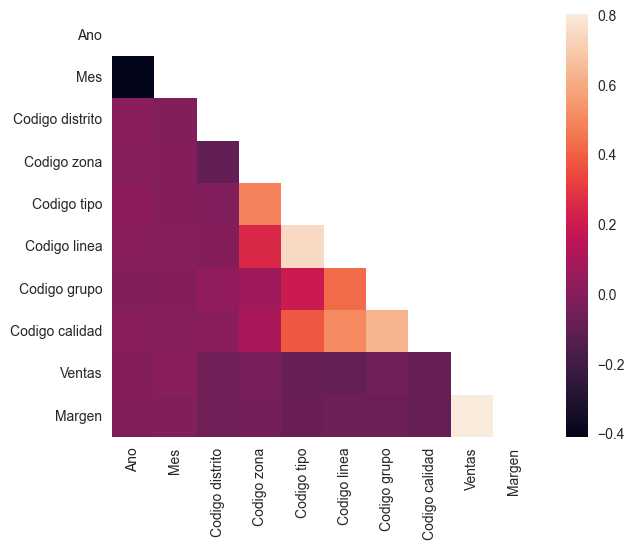

In [17]:
corr_matrix = df_vta.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask= mask, square= True)
plt.show()

In [10]:
list_dst_znas = (df_vta["Codigo distrito"].astype(str) + "-" + df_vta["Codigo zona"].astype(str)).unique()
categorical_columns = ["Ano", "Mes", "Codigo distrito", "Codigo zona", "Nit cliente","Nombre cliente", "Codigo tipo",
                        "Codigo linea", "Codigo grupo", "Codigo calidad", "Gerente", "Linea CAM", "Codigo distrito-zona"]
ignore_columns = ["Ano", "Mes", "Codigo grupo", "Codigo calidad", "Codigo distrito-zona"]
numerical_columns = ["Ventas", "Costo", "Margen"]

In [11]:
consolidado = pd.DataFrame([])
for n, dtozna in enumerate(list_dst_znas):
    print(f"Procesando {n+1} de {len(list_dst_znas)}. {(n+1) / (len(list_dst_znas)):.1%}")
    #Creacion del subdataset
    df_dto = df_vta[df_vta["Codigo distrito-zona"] == dtozna]
    
    #Setup modelo
    exp_vta = setup(df_dto, 
                        session_id = 42,
                        silent= True,
                        profile= False,
                        categorical_features = categorical_columns,
                        numeric_features = numerical_columns,
                        ignore_features = ignore_columns,
                        normalize = True,
                        normalize_method = 'robust',
                        verbose = False)
    
    #Modelo iforest
    iforest = create_model('iforest')
    iforest_results = assign_model(iforest)
    resultado_iforest = iforest_results
    # resultado_iforest = iforest_results.loc[(iforest_results["Anomaly_Score"] >= 0.02) &
                                            # ((iforest_results["Ventas"] >= 2000000) | (iforest_results["Margen"] < 0))
                                            # (iforest_results["Ano"] == 2023) & 
                                            # (iforest_results["Mes"] == 1)
                                            # ]

    #Append a una base general
    consolidado = consolidado.append(resultado_iforest)

#Consolidacion de la base general
consolidado.index = pd.RangeIndex(len(consolidado.index))


print("Proceso completo 100%")

Proceso completo 100%


In [12]:
consolidado.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Anomaly detection/Anomalies_iforest/Anomalies ene23 6-2-23.csv",
                    encoding= 'utf-8', index= False, sep= ";", decimal = ",")

#### Modelo Margen %

In [82]:
fecha_inicio = "'2022-08-01'"
fecha_final = "'2023-01-31'"

In [85]:
codigo_SQL = f"SELECT A.VTAANO AS 'Ano', A.VTAMES AS 'Mes', A.DSTCOD AS 'Codigo distrito', A.VTAZNA AS 'Codigo zona', A.VTANIT AS 'Nit cliente', C.NITNOM AS 'Nombre cliente', A.VTAPRDCOD AS 'Codigo producto', A.VTANUMDOC AS 'Documento', SUM(A.VTAVLRVTA) AS 'Ventas', SUM(A.VTACST) AS 'Costo' FROM V_VTA_VTAHEC A LEFT JOIN DIM_PRODUCTOS B ON A.PRMCOD = B.PRMCOD AND A.VTAPRDCOD = B.PRDCOD LEFT JOIN DIM_NITS C ON A.VTANIT = C.NITNIT WHERE A.PRMCOD = 1 AND A.DSTCOD != 30 AND A.VTAZNA < 96 AND A.VTAFCH BETWEEN {fecha_inicio} AND {fecha_final} AND  B.TPOCOD NOT IN (990,999) GROUP BY A.VTAANO, A.VTAMES, A.DSTCOD, A.VTAZNA, A.VTANIT, C.NITNOM, A.VTAPRDCOD, A.VTANUMDOC"

In [86]:
#Cargue de la data desde el dwh de Dispapeles y se guarda en df
cursor.execute(codigo_SQL)
rows = cursor.fetchall()
df = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

In [89]:
maestra_gerencias = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Anomaly detection/Maestra_gerencias.csv', delimiter= ";")
maestra_zonas = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/Análisis clustering/Maestra_zonas.csv', delimiter= ";")
maestra_zonas = maestra_zonas.rename(columns= {"Codigo zona actual": "Codigo zona"})

In [90]:
df_merged = pd.merge(df, maestra_gerencias, on= "Codigo producto")
df_merged["Margen porcentaje"] = round((1 - (df_merged["Costo"].astype(int)) / (df_merged["Ventas"].astype(int))).astype(float) * 100,2)

In [92]:
df_mgn = df_merged.drop(["Ventas", "Costo"], axis= 1)
# df_mgn = df_mgn.reset_index(col_level= 1)
df_mgn["Codigo distrito-zona"] = df_mgn["Codigo distrito"].astype(str) + "-" + df_mgn["Codigo zona"].astype(str)
df_mgn.head()

,Ano,Mes,Codigo distrito,Codigo zona,Nit cliente,Nombre cliente,Codigo producto,Documento,Gerente,Linea CAM,Margen porcentaje,Codigo distrito-zona
0,2022,12,10,73,890200756,BANCO PICHINCHA S.A.S,10675,1469374,Resmilla,Resmilla - Natural,33.86,10-73
1,2022,11,20,63,800222159,DIST.DE OCCIDENTE LIMITADA DISTRITIENDAS,10675,1432572,Resmilla,Resmilla - Natural,14.81,20-63
2,2022,11,10,69,901161636,MEDIA RES STAKHOUSE S.A.S,10675,1463885,Resmilla,Resmilla - Natural,15.05,10-69
3,2022,11,40,63,890901352,EL COLOMBIANO S.A.S,10675,1448450,Resmilla,Resmilla - Natural,13.14,40-63
4,2022,11,60,61,900985371,DISTRICONSUMO DE COLOMBIA S.A.S,10675,1407118,Resmilla,Resmilla - Natural,16.01,60-61


In [94]:
list_dst_znas = (df_mgn["Codigo distrito"].astype(str) + "-" + df_mgn["Codigo zona"].astype(str)).unique()
categorical_columns = ["Ano", "Mes", "Codigo distrito", "Codigo zona", "Nit cliente","Nombre cliente", "Codigo producto",
                        "Documento", "Gerente", "Linea CAM", "Codigo distrito-zona"]
ignore_columns = ["Ano", "Mes", "Codigo distrito-zona"]
numerical_columns = ["Margen porcentaje"]

In [95]:
consolidado_mgn = pd.DataFrame([])
for n, dtozna in enumerate(list_dst_znas):
    print(f"Procesando {n+1} de {len(list_dst_znas)}. {(n+1) / (len(list_dst_znas)):.1%}")
    #Creacion del subdataset
    df_dto = df_mgn[df_mgn["Codigo distrito-zona"] == dtozna]
    
    #Setup modelo
    exp_mgn = setup(df_dto, 
                        session_id = 42,
                        silent= True,
                        profile= False,
                        categorical_features = categorical_columns,
                        numeric_features = numerical_columns,
                        ignore_features = ignore_columns,
                        normalize = True,
                        normalize_method = 'robust',
                        verbose = False)
    
    #Modelo iforest
    iforest = create_model('iforest')
    iforest_results = assign_model(iforest)
    resultado_iforest = iforest_results
    # resultado_iforest = iforest_results.loc[(iforest_results["Anomaly_Score"] >= 0.02) &
                                            # ((iforest_results["Ventas"] >= 2000000) | (iforest_results["Margen"] < 0))
                                            # (iforest_results["Ano"] == 2023) & 
                                            # (iforest_results["Mes"] == 1)
                                            # ]

    #Append a una base general
    consolidado_mgn = consolidado_mgn.append(resultado_iforest)

#Consolidacion de la base general
consolidado_mgn.index = pd.RangeIndex(len(consolidado_mgn.index))


print("Proceso completo 100%")

Proceso completo 100%


In [96]:
consolidado_mgn.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Anomaly detection/Anomalies_iforest/Anomalies margen ene23 2-2-23.csv",
                    encoding= 'utf-8', index= False, sep= ";", decimal = ",")